In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import warnings
warnings.filterwarnings(action='ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity ='all'

import time
from tqdm.notebook import tqdm

import datetime
from datetime import timedelta
import re

import networkx as nx
import chart_studio
chart_studio.tools.set_credentials_file(username='username', api_key='api_key')
import chart_studio.plotly as py
import plotly.express as px
from matplotlib import font_manager, rc

rc('font',family = 'Malgun Gothic')
plt.style.use('ggplot')

In [2]:
data = pd.read_excel('network.xlsx')

In [3]:
data=data.sort_values(by='날짜').reset_index(drop=True)

In [8]:
# large = ['동부구치소','성북구사랑제일교회','해외']
# data = data[~data['virus_route'].isin(large)].reset_index(drop=True)
# data

,거주지,날짜,세부정보,퇴원현황,환자번호,virus_route
0,종로구,2020-01-30,이동경로 공개기간 경과,퇴원,6,3
1,종로구,2020-01-31,이동경로 공개기간 경과,퇴원,11,6
2,성북구,2020-01-31,이동경로 공개기간 경과,퇴원,9,5
3,종로구,2020-01-31,이동경로 공개기간 경과,퇴원,10,6
4,성북구,2020-02-05,이동경로 공개기간 경과,퇴원,21,6
...,...,...,...,...,...,...
16931,도봉구,2020-12-31,기타 확진자 접촉,입원,61339,기타확진자
16932,중랑구,2020-12-31,기타 확진자 접촉,입원,60792,기타확진자
16933,광진구,2020-12-31,기타 확진자 접촉,입원,61634,기타확진자
16934,강북구,2020-12-31,감염경로 조사중,입원,61043,감염경로조사중


In [43]:
def Measure(data, start_month, start_day , time_delta,rep):  
   
    day = pd.to_datetime("2020-"+str(start_month).zfill(2)+"-"+str(start_day))  # 시작날짜 초기화
    start = day - timedelta(days=3)
    end = day + timedelta(days=3)
    output = pd.DataFrame() # 시기별 중심성지표 빈 데이터프레임 만들기
    
    def density(graph):
        if len(graph.edges()) <2:
            return 0
        else:
            return len(graph.edges()) / (len(graph.nodes()) * (len(graph.nodes()) - 1))
    
    def AVG_COEF(graph):
        nodes = list(graph.nodes())
        edges = list(graph.edges())
        
        if len(nodes) < 2:
            return 0 
        else:
            deg = []  # deg()
            for n in nodes:
                a = []
                for i in edges:
                    if i[0] == n:
                        a.append(i[1])   # 각 노드에 대한 degree 구하기
                    elif i[1] == n:
                        a.append(i[0])
                    else:
                        continue

                if len(a) < 2 :
                    deg.append(0)
                else:
                    deg.append(len(edges) / (len(a)*(len(a)-1)))
                
            return sum(deg) / len(nodes)

    def modularity(graph):
        nodes = list(graph.nodes())
        edges = list(graph.edges())
        deg = []
        modular = []
        if len(nodes) < 2 :
            return 0
        else:
            for n in nodes:
                a = []
                for i in edges:
                    if i[0] == n :
                        a.append(i[1])   # 각 노드에 대한 degree 구하기
                    elif i[1] == n:
                        a.append(i[0])
                    else:
                        continue

                deg.append(len(a))

            for i in range(len(deg)):
                for j in range(i+1,len(deg)):
                    modular.append(deg[i]*deg[j] / (2*len(edges)))
                
        return sum(modular) / len(modular)    
    
    ## 그래프 형태에 따른 ADIndex
    def ADIndex_pv(graph):
        nodes = list(graph.nodes())
        edges = list(graph.edges())
        
        if len(nodes) < 2 :
            return 0
        else:
            return 6 / (len(nodes)*(len(nodes)+1))
        
    def ADIndex_sv(graph):
        nodes = list(graph.nodes())
        edges = list(graph.nodes())
        
        if len(nodes) < 2 :
            return 0
        else:
            return 1/(len(nodes)-1)
        
    def ADIndex_cv(graph):
        nodes = list(graph.nodes())
        edges = list(graph.edges())
        
        if len(nodes) < 2 :
            return 0
        elif len(nodes) % 2 == 1:
            return 8/(len(nodes)**2 -1)
        else:
            return 8/(len(nodes)**2)
        
    def B_sv(graph):
        nodes = list(graph.nodes())
        edges = list(graph.nodes())

        if len(nodes) < 2 :
            return 0
        else:
            return (3*len(nodes)-4)/(2*len(nodes)-3)

    def B_cv(graph):
        nodes = list(graph.nodes())
        edges = list(graph.nodes())

        if len(nodes) < 2 :
            return 0
        elif len(nodes) % 2 == 1:
            return 8*len(nodes)/(len(nodes)**2 -1)
        else:
            return 8/(len(nodes))
############################################################################################################

    date = []   
    dense = []
    avg_coef =[]
    modul = []
    ad_pv = []
    ad_sv = []
    ad_cv = []
    b_sv = []
    b_cv = []
    
    for i in range(rep):
        
        df = data[ data['날짜'] >= start][data['날짜'] <=end].reset_index(drop=True) # 시작날짜 ~ 종료날짜 해당하는 DF 추출
        edges = []   # Empty Edge list
        for j in range(len(df)):
            edges.append((str(df['virus_route'][j]),str(df['환자번호'][j]),1)) # Edge 만들기
            
        G = nx.Graph() # 그래프 생성
        G.add_weighted_edges_from(edges) # 그래프 안에서 Edge 연결
        
        date.append(day)
        dense.append(density(G))
        avg_coef.append(AVG_COEF(G))
        modul.append(modularity(G))
        ad_pv.append(ADIndex_pv(G))
        ad_sv.append(ADIndex_sv(G))
        ad_cv.append(ADIndex_cv(G))
        b_sv.append(B_sv(G))
        b_cv.append(B_cv(G))
        day = day + timedelta(days=time_delta)  # 종료날짜다음날부터를 시작날짜로 재설정
        start = day - timedelta(days=3)
        end = day + timedelta(days=3)        
        
    output = pd.DataFrame({'Date' : date , 'Density' : dense, 'AVG_COEF' : avg_coef , 'Modularity' : modul,
                           'AD_Pv' : ad_pv, 'AD_Sv': ad_sv, 'AD_Cv': ad_cv, 'B_Sv':b_sv, 'B_Cv':b_cv})
    

    return output

In [45]:
a = Measure(data, start_month=1, start_day=30 , time_delta=1,rep=368) # 276
a.head()

,Date,Density,AVG_COEF,Modularity,AD_Pv,AD_Sv,AD_Cv,B_Sv,B_Cv
0,2020-01-30,0.097222,0.648148,0.166667,0.066667,0.125000,0.100000,1.533333,0.900000
1,2020-01-31,0.097222,0.648148,0.166667,0.066667,0.125000,0.100000,1.533333,0.900000
2,2020-02-01,0.097222,0.648148,0.166667,0.066667,0.125000,0.100000,1.533333,0.900000
3,2020-02-02,0.081818,0.545455,0.141414,0.045455,0.100000,0.066667,1.526316,0.733333
4,2020-02-03,0.077778,0.233333,0.134921,0.054545,0.111111,0.080000,1.529412,0.800000


In [5]:
a = pd.read_csv('measure.csv')

In [6]:
del a['Unnamed: 0']

In [7]:
a['Date'] = pd.to_datetime(a['Date'])

## Smoothing
- data shape before processing smoothing

In [8]:
cum = pd.pivot_table(data,index='날짜',aggfunc='count').reset_index().iloc[:,0:2]
cum.rename(columns={'virus_route':'확진자수'},inplace=True)
cum2 = pd.DataFrame({'날짜':pd.date_range(start='1/30/2020', end='1/31/2021')})
cum2 = pd.merge(cum2,cum,how='left').fillna(0)
cum2.rename(columns={'날짜':'Date'},inplace=True)
cum3 = pd.merge(cum2,a,how='left')
cum3.head()

,Date,확진자수,Density,AVG_COEF,Modularity,AD_Pv,AD_Sv,AD_Cv,B_Sv,B_Cv
0,2020-01-30,3.0,0.097222,0.648148,0.166667,0.066667,0.125000,0.100000,1.533333,0.900000
1,2020-01-31,3.0,0.097222,0.648148,0.166667,0.066667,0.125000,0.100000,1.533333,0.900000
2,2020-02-01,0.0,0.097222,0.648148,0.166667,0.066667,0.125000,0.100000,1.533333,0.900000
3,2020-02-02,1.0,0.081818,0.545455,0.141414,0.045455,0.100000,0.066667,1.526316,0.733333
4,2020-02-03,0.0,0.077778,0.233333,0.134921,0.054545,0.111111,0.080000,1.529412,0.800000


In [9]:
toto = cum3[['Date','확진자수']]
toto.to_excel('일일확진자.xlsx',index=False)

- smoothing

In [60]:
current_day= []
num = []
density = []
avg_coef = []
modul = []
adpv = []
adsv = []
adcv = []
bsv = []
bcv = []

for i in pd.date_range(start='1/30/2020',end='1/31/2021'):
    day = i
    start = day - timedelta(days=3)
    end = day + timedelta(days=3)
    df = cum3[ cum3['Date'] >= start][cum3['Date'] <=end].reset_index(drop=True)

    current_day.append(day)
    num.append(df['확진자수'].sum()/7)
    density.append(df['Density'].sum()/7)
    avg_coef.append(df['AVG_COEF'].sum()/7)
    modul.append(df['Modularity'].sum()/7)
    adpv.append(df['AD_Pv'].sum()/7)
    adsv.append(df['AD_Sv'].sum()/7)
    adcv.append(df['AD_Cv'].sum()/7)
    bsv.append(df['B_Sv'].sum()/7)
    bcv.append(df['B_Cv'].sum()/7)

In [61]:
len(current_day) , len(num), len(density), len(avg_coef) , len(modul) , len(adpv) , len(adsv), len(adcv) , len(bsv), len(bcv)

(368, 368, 368, 368, 368, 368, 368, 368, 368, 368)

- final data

In [379]:
total = pd.DataFrame({'Date' : current_day , 'infected' : num , 'Density' : density , 'AVG_COEF' : avg_coef,
                      'Modularity' : modul})
total.head(3)

,Date,infected,Density,AVG_COEF,Modularity
0,2020-01-30,1.0,0.053355,0.355700,0.091631
1,2020-01-31,1.0,0.064466,0.389033,0.110905
2,2020-02-01,1.0,0.081473,0.397537,0.137436


In [380]:
# N주전 변수 추가 함수 
def add_nweeks_before(data,column,week):
    avg_infected = [] 
    for k in pd.date_range(start='01/30/2020',end='1/31/2021'):
        day = k
        start = day - timedelta(days= week * 7)
        end = day - timedelta(days=1)
        df = data[ data['Date'] >= start][data['Date'] <=end].reset_index(drop=True)
        avg_infected.append(sum(df[column]/(week*7)))
    col_name = str(week)+'week_before_' + column
    data[col_name] = avg_infected
    return data

In [381]:
# 모든 컬럼에 대해 2주전까지의 지표와 상관성을 보기위해서 기존 컬럼들과 n주차 조합을 통해 새로운 데이터 생성하기
colnames = total.columns.tolist()[1:]
nweek = [1,2,3,4]

In [382]:
for col in colnames:
    for weeks in nweek:
        total = add_nweeks_before(total , col , weeks)

# 기존 컬럼들 지우기
total = total[total.columns.difference(colnames[1:])] # infected는 남겨

### 1. Modeling with linear & nonlinear regression

In [260]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error

In [383]:
train = total[(total['Date']>='2020-01-30') & (total['Date']<='2020-10-28')] # 12월 1일 스무딩에 들어가는 11/28 ~ 30 은 제거해줌
test = total[(total['Date']>='2020-11-01') & (total['Date']<='2021-01-28')]

- 1 . Simple Linear Regression

In [367]:
scores = []
coef = []
for i in range(16):
    X_train , y_train = train.iloc[:,i] , train.iloc[:,17] # 20번째 컬럼이 infected y변수
    X_test  , y_test  = test.iloc[:,i] , test.iloc[:,17]
    model = LinearRegression()
    model.fit(np.array(X_train).reshape(-1,1), y_train)
    y_pred = model.predict(np.array(X_test).reshape(-1,1))
    scores.append(mean_squared_error(y_test,y_pred))
    coef.append(model.coef_[0])

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [384]:
pd.DataFrame({'var':train.columns[:16], 'mse' : scores , 'coef' : coef}).sort_values(by='mse')

,var,mse,coef
3,1week_before_infected,1427.431413,0.940702
7,2week_before_infected,4090.821889,0.859341
11,3week_before_infected,7681.636063,0.780185
15,4week_before_infected,11204.409010,0.727397
8,3week_before_AVG_COEF,29797.000844,15.958607
12,4week_before_AVG_COEF,30321.228665,15.242842
4,2week_before_AVG_COEF,30357.661597,15.365092
0,1week_before_AVG_COEF,31569.666032,14.097731
14,4week_before_Modularity,38955.597005,-192.779085
13,4week_before_Density,39111.567175,-297.980945


### 2 . Multiple Linear Regression

- Using all features

In [402]:
X_train, y_train = train[train.columns.difference(['Date','infected'])] , train['infected']
X_test, y_test = test[test.columns.difference(['Date','infected'])] , test['infected']

model = LinearRegression()
model.fit(X_train,y_train)
model.coef_  

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

array([-3.40087108e+00,  2.86284335e+02, -1.70766090e+02,  2.00424133e+00,
        1.60248347e+01, -2.33191931e+02,  1.71405023e+02, -1.39961967e+00,
       -1.02159504e+01, -4.59880355e+01, -3.36357544e+01, -2.09109324e-02,
       -1.50317377e+00,  2.02172073e+02, -1.09141474e+02,  3.13750840e-01])

- predict

In [403]:
y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

990.9411012519836

- 비교

In [404]:
np.array(y_pred)
np.array(y_test)

## 가장 영향력 있는 변수는 AVG_COEFF

array([ 42.06866575,  45.7075708 ,  47.60267572,  48.05340973,
        47.57132763,  47.56195334,  47.66061521,  47.069865  ,
        45.62906976,  45.65783124,  47.18376879,  49.25086509,
        51.36891096,  54.8921246 ,  60.42949956,  68.29582659,
        76.85597929,  86.88592506,  97.25019867, 107.49770089,
       116.39831469, 124.34456569, 132.46736247, 140.34615832,
       145.44810459, 150.68397693, 156.63637133, 163.17335997,
       170.32805901, 175.60089096, 181.45940761, 189.11857053,
       197.86417782, 207.35843104, 217.23680472, 226.66518098,
       235.16064378, 239.44686212, 245.36294455, 251.87187692,
       254.43009181, 256.07826724, 259.82265168, 269.54167349,
       286.30166018, 298.29392246, 302.20520627, 311.75035516,
       322.52008087, 328.82901117, 324.45135883, 318.09830804,
       316.99967959, 326.3350459 , 330.08244594, 337.20064713,
       346.40616332, 364.28186532, 371.86633196, 365.12535696,
       347.44923301, 332.68824654, 301.57260195, 266.51

array([ 40.28571429,  38.57142857,  37.28571429,  38.57142857,
        41.57142857,  43.        ,  43.28571429,  44.        ,
        48.85714286,  53.42857143,  57.85714286,  62.71428571,
        70.71428571,  77.42857143,  85.42857143,  93.71428571,
       106.14285714, 111.28571429, 115.85714286, 121.71428571,
       128.85714286, 143.57142857, 153.85714286, 157.        ,
       162.14285714, 168.57142857, 172.14285714, 179.42857143,
       186.14285714, 199.28571429, 206.85714286, 220.57142857,
       233.        , 241.71428571, 250.85714286, 249.57142857,
       243.28571429, 262.        , 282.        , 278.42857143,
       283.42857143, 300.28571429, 325.28571429, 345.57142857,
       344.28571429, 324.14285714, 339.28571429, 348.14285714,
       346.85714286, 329.71428571, 352.42857143, 368.14285714,
       382.85714286, 380.42857143, 410.        , 411.71428571,
       420.71428571, 392.57142857, 344.14285714, 320.71428571,
       323.85714286, 277.28571429, 260.42857143, 250.42

- 유의미한 변수만

- ,'1week_before_AVG_COEF','1week_before_Density','1week_before_Modularity'

In [421]:
sig_features = ['4week_before_infected','4week_before_AVG_COEF']
X_train, y_train = train[sig_features] , train['infected']
X_test, y_test = test[sig_features] , test['infected']

- fitting & predicting

In [422]:
model = LinearRegression()
model.fit(X_train,y_train)
model.coef_  

y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

array([ 0.73085532, -0.14732276])

11194.611287312871

- 비교

In [423]:
np.array(y_pred)
np.array(y_test)
## 가장 영향력 있는 변수는 AVG_COEFF

array([ 23.87337098,  24.40014523,  24.8429392 ,  25.25655753,
        25.67415353,  26.12513987,  26.60508138,  27.12013578,
        27.63330933,  28.28558074,  29.08155115,  30.0086816 ,
        31.1223288 ,  32.47252935,  34.02914442,  35.82100292,
        37.82158504,  40.13178316,  42.58517469,  45.1271112 ,
        47.78980268,  50.57456345,  53.69549367,  56.96601139,
        60.22879243,  63.52261335,  66.97587895,  70.51495917,
        74.19986305,  77.99473636,  82.17565477,  86.58717245,
        91.32291273,  96.30579733, 101.480302  , 106.88663469,
       112.24258442, 117.30949542, 122.74687171, 128.59036155,
       134.2128366 , 139.75457057, 145.55907294, 151.80614695,
       158.36718118, 164.57121303, 170.11835917, 175.94431604,
       181.85369154, 187.54657019, 192.41088311, 197.60222965,
       203.12370281, 208.89596346, 214.43975606, 220.66217162,
       226.73877063, 232.87467954, 237.93267958, 241.52787391,
       244.15145765, 246.53020607, 247.46448444, 247.72

array([ 40.28571429,  38.57142857,  37.28571429,  38.57142857,
        41.57142857,  43.        ,  43.28571429,  44.        ,
        48.85714286,  53.42857143,  57.85714286,  62.71428571,
        70.71428571,  77.42857143,  85.42857143,  93.71428571,
       106.14285714, 111.28571429, 115.85714286, 121.71428571,
       128.85714286, 143.57142857, 153.85714286, 157.        ,
       162.14285714, 168.57142857, 172.14285714, 179.42857143,
       186.14285714, 199.28571429, 206.85714286, 220.57142857,
       233.        , 241.71428571, 250.85714286, 249.57142857,
       243.28571429, 262.        , 282.        , 278.42857143,
       283.42857143, 300.28571429, 325.28571429, 345.57142857,
       344.28571429, 324.14285714, 339.28571429, 348.14285714,
       346.85714286, 329.71428571, 352.42857143, 368.14285714,
       382.85714286, 380.42857143, 410.        , 411.71428571,
       420.71428571, 392.57142857, 344.14285714, 320.71428571,
       323.85714286, 277.28571429, 260.42857143, 250.42

- test 예측

In [424]:
sam = pd.DataFrame({'actual':y_test, 'pred':y_pred,'4주전':X_test['4week_before_infected'],
                    'date':pd.date_range(start='11/01/2020',end='1/28/2021')})

0.6006459523702631

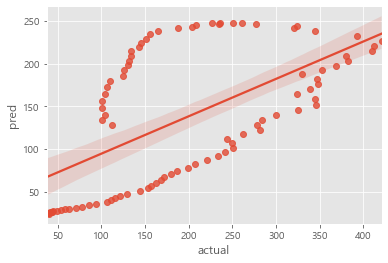

In [425]:
#fig = px.line(sam, x="date", y=["actual","pred","1주전","2주전","3주전","4주전"])
fig = px.line(sam, x="date", y=["actual","pred","4주전"])
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
              yaxis_showgrid=False,width=900, height=600,
              title='1주전Infected')

## 다소 선행
sns.regplot(data = sam,x='actual',y='pred')
sam['actual'].corr(sam['pred'])

- train 예측

In [29]:
sig_features = ['2week_before_infected','1week_before_infected']
X_train, y_train = train[sig_features] , train['infected']
X_test, y_test = test[sig_features] , test['infected']
model = LinearRegression()
model.fit(X_train,y_train)
model.coef_  

y_pred = model.predict(X_test)
mean_squared_error(y_test, y_pred)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

array([-0.984252 ,  1.9278887])

1088.7903736428411

0.7564631558187905

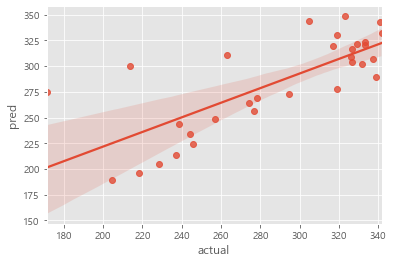

In [30]:
sam = pd.DataFrame({'actual':y_test, 'pred':y_pred,'date':pd.date_range(start='11/01/2020',end='1/28/2021')})

fig = px.line(sam, x="date", y=["actual","pred"])
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
              yaxis_showgrid=False,width=900, height=600,
              title='Density')

## 다소 선행
sns.regplot(data = sam,x='actual',y='pred')
sam['actual'].corr(sam['pred'])

In [128]:
predy = model.predict(X_train)

0.9741971843128373

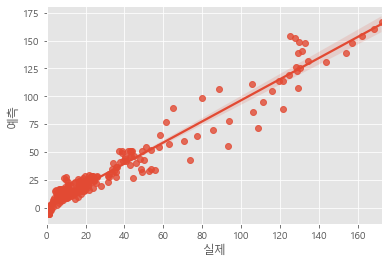

In [129]:
tt = pd.DataFrame({'실제':y_train , '예측':predy})
sns.regplot(data = tt,x='실제',y='예측')
tt['실제'].corr(tt['예측'])

### 3.  Tree-based RandomForest Regression

In [130]:
X_train, y_train = train[train.columns.difference(['Date','infected'])] , train['infected']
X_test, y_test = test[test.columns.difference(['Date','infected'])] , test['infected']

regr = RandomForestRegressor(n_estimators=200 ,random_state=25)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
mean_squared_error(y_test, y_pred)

np.array(y_pred)
np.array(y_test)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=25, verbose=0,
                      warm_start=False)

29030.231556023577

array([156.12285714, 156.12285714, 156.12285714, 156.12285714,
       156.12285714, 156.06714286, 156.06714286, 155.915     ,
       155.76285714, 155.68642857, 155.68642857, 155.76285714,
       155.76285714, 155.915     , 155.915     , 156.06714286,
       156.06714286, 155.915     , 155.915     , 154.575     ,
       152.125     , 151.18428571, 150.85642857, 151.30857143,
       150.85357143, 150.305     , 151.22428571, 151.04214286,
       143.34785714, 139.87928571, 140.12928571])

array([206.85714286, 220.57142857, 233.        , 241.71428571,
       250.85714286, 249.57142857, 243.28571429, 262.        ,
       282.        , 278.42857143, 283.42857143, 300.28571429,
       325.        , 345.28571429, 343.28571429, 322.85714286,
       338.        , 346.71428571, 345.28571429, 328.28571429,
       350.85714286, 366.85714286, 381.85714286, 378.28571429,
       408.        , 409.85714286, 418.71428571, 390.28571429,
       324.57142857, 273.85714286, 231.        ])

In [131]:
regr.feature_importances_
pd.DataFrame({'importance':regr.feature_importances_,
              'columns' : X_train.columns}).sort_values(by='importance',ascending=False)

array([0.00463534, 0.00521042, 0.00397882, 0.01950621, 0.00475025,
       0.00378032, 0.00529286, 0.00685404, 0.83346802, 0.00612124,
       0.00599971, 0.0041317 , 0.07351894, 0.0038826 , 0.00351823,
       0.00407128, 0.00348188, 0.00779814])

,importance,columns
8,0.833468,1week_before_infected
12,0.073519,2week_before_AVG_COEF
3,0.019506,1week_before_AVG_COEF
17,0.007798,2week_before_infected
7,0.006854,1week_before_Modularity
9,0.006121,2week_before_AD_Cv
10,0.006000,2week_before_AD_Pv
6,0.005293,1week_before_Density
1,0.005210,1week_before_AD_Pv
4,0.004750,1week_before_B_Cv


In [132]:
sig_features = ['1week_before_AVG_COEF','1week_before_infected','2week_before_AVG_COEF','2week_before_infected']
X_train, y_train = train[sig_features] , train['infected']
X_test, y_test = test[sig_features] , test['infected']

regr = RandomForestRegressor(n_estimators=200 ,random_state=25)
regr.fit(X_train, y_train)

y_pred = regr.predict(X_test)
mean_squared_error(y_test, y_pred)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=200,
                      n_jobs=None, oob_score=False, random_state=25, verbose=0,
                      warm_start=False)

31816.07670916715

In [133]:
regr.feature_importances_
pd.DataFrame({'importance':regr.feature_importances_,
              'columns' : X_train.columns}).sort_values(by='importance',ascending=False)

array([0.03328767, 0.85723464, 0.08605479, 0.02342291])

,importance,columns
1,0.857235,1week_before_infected
2,0.086055,2week_before_AVG_COEF
0,0.033288,1week_before_AVG_COEF
3,0.023423,2week_before_infected


## 4. Nonlinear Regression  - > y변수에 지수함수 씌우고 예측

In [334]:
idx = total.index[total['infected']==0]

In [335]:
total.iloc[idx,17] = 0.1

In [336]:
train = total[(total['Date']>='2020-01-31') & (total['Date']<='2020-10-28')] # 12월 1일 스무딩에 들어가는 11/28 ~ 30 은 제거해줌
test = total[(total['Date']>='2020-11-01') & (total['Date']<='2021-01-28')]

In [322]:
scores = []
coef = []
for i in range(16):
    X_train , y_train = train.iloc[:,i] , np.exp(train.iloc[:,17]) # 20번째 컬럼이 infected y변수
    X_test  , y_test  = test.iloc[:,i] , test.iloc[:,17]
    model = LinearRegression(fit_intercept=False)   # 지수함수형태에서 교차항제거 -> 음수나옴
    model.fit(np.array(X_train).reshape(-1,1), y_train)
    y_pred = model.predict(np.array(X_test).reshape(-1,1))
    y_pred = np.log(y_pred)
    scores.append(mean_squared_error(y_test,y_pred))
    coef.append(model.coef_[0])
    print(i)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

0


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

1


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

2


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

3


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

4


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

5


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

6


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

7


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

8


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

9


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

10


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

11


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

12


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

13


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

14


LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

15


In [323]:
pd.DataFrame({'var':train.columns[:16], 'mse' : scores , 'coef' : coef}).sort_values(by='mse')

,var,mse,coef
3,1week_before_infected,15626.338808,1.259032e+55
7,2week_before_infected,15648.318655,1.112271e+55
11,3week_before_infected,15693.553078,8.535972e+54
15,4week_before_infected,15732.690329,7.115741e+54
12,4week_before_AVG_COEF,15958.486940,9.128197e+55
8,3week_before_AVG_COEF,15959.843100,9.198557e+55
4,2week_before_AVG_COEF,15982.815717,8.109895e+55
0,1week_before_AVG_COEF,16002.338151,7.493986e+55
14,4week_before_Modularity,16945.026809,3.383204e+56
13,4week_before_Density,17001.897440,4.304553e+56


- 변수설정하면 해당 변수의 영향 파악가능

In [399]:
sig_features = ['4week_before_Modularity','4week_before_Density','4week_before_infected']
X_train, y_train = train[sig_features] , train['infected']
X_test, y_test = test[sig_features] , test['infected']

In [400]:
model = LinearRegression(fit_intercept=False)   # 지수함수형태에서 교차항제거 -> 음수나옴
#model.fit(np.array(X_train).reshape(-1,1), y_train)
model.fit(np.exp(X_train),np.exp(y_train))
#y_pred = model.predict(np.array(X_test).reshape(-1,1))
y_pred = model.predict(np.exp(X_test))
y_pred = np.log(y_pred)
mean_squared_error(y_test, y_pred)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

9712.30434561447

In [340]:
X_train , y_train = np.exp(train.iloc[:,:16]) , np.exp(train.iloc[:,17]) # 20번째 컬럼이 infected y변수
X_test  , y_test  = np.exp(test.iloc[:,:16]) , test.iloc[:,17]
model = LinearRegression(fit_intercept=False)   # 지수함수형태에서 교차항제거 -> 음수나옴
#model.fit(np.array(X_train).reshape(-1,1), y_train)
model.fit(X_train,y_train)
#y_pred = model.predict(np.array(X_test).reshape(-1,1))
y_pred = model.predict(X_test)
y_pred = np.log(y_pred)
mean_squared_error(y_test, y_pred)

LinearRegression(copy_X=True, fit_intercept=False, n_jobs=None, normalize=False)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

0.6013764891365475

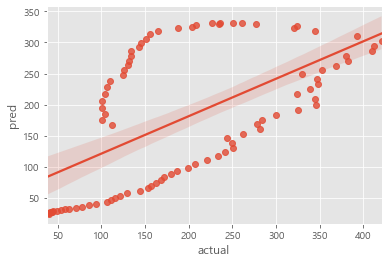

In [401]:
sam = pd.DataFrame({'actual':y_test, 'pred':y_pred,'4주전':(X_test['4week_before_infected']),
                    'date':pd.date_range(start='11/01/2020',end='1/28/2021')})

fig = px.line(sam, x="date", y=["actual","pred","4주전"])
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
              yaxis_showgrid=False,width=900, height=600,
              title='Density')

sns.regplot(data = sam,x='actual',y='pred')
sam['actual'].corr(sam['pred'])

### train은 잘맞추나

In [140]:
predy = model.predict(X_train)

In [141]:
sam = pd.DataFrame({'actual':train.iloc[:,19], 'pred':predy})

fig = px.line(sam, x="actual", y=["pred"])
fig.update_layout(plot_bgcolor='white',xaxis_showgrid=False, 
              yaxis_showgrid=False,width=900, height=600,
              title='Density')

## 다소 선행

In [142]:
pd.DataFrame({'var':train.columns[:18], 'mse' : scores , 'coef' : coef}).sort_values(by='mse')

,var,mse,coef
8,1week_before_infected,23943.151123,1.680463e+71
17,2week_before_infected,23976.234073,1.636551e+71
3,1week_before_AVG_COEF,24394.711332,3.085144e+72
12,2week_before_AVG_COEF,24405.637036,2.613813e+72
14,2week_before_B_Sv,24842.244145,1.535408e+72
5,1week_before_B_Sv,24846.444480,1.514508e+72
15,2week_before_Density,26976.981899,3.553701e+72
6,1week_before_Density,27149.961309,2.169647e+72
16,2week_before_Modularity,27204.481723,9.013160e+71
7,1week_before_Modularity,27377.186479,5.562810e+71


0.9487006346720146

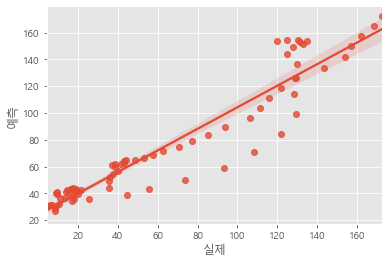

In [143]:
tt = pd.DataFrame({'실제':np.log(y_train) , '예측':np.log(predy)})
sns.regplot(data = tt,x='실제',y='예측')
tt['실제'].corr(tt['예측'])